# Pipeline End-to-End: YOLO → ResNet (Translation + Rotation) → 6D Pose (Minimal Version)
Questa versione minimale esegue la pipeline end-to-end per la stima della posa 6D su LineMOD, ispirata al notebook test6_extension_endtoend_pipeline.ipynb.

**Nota:** Questa pipeline minimale esegue solo un batch di test e mostra la traduzione e la rotazione predette. Per valutazioni complete e metriche, vedere il notebook originale test6_extension_endtoend_pipeline.ipynb.

## 1. Import essenziali e setup minimal

In [1]:
# Import essenziali e setup minimal
import os
import sys
import pandas as pd
from pathlib import Path
import torch

sys.path.insert(0, str(Path.cwd().parent))
from config import Config
from models.pose_estimator_endtoend import PoseEstimator
from models.yolo_detector import YOLODetector
from dataset.linemod_pose import create_pose_dataloaders
from utils.file_io import load_validation_results
from utils.visualization import plot_add_per_class, calc_add_accuracy_per_class
from utils.validation import run_yolo_endtoend_pipeline


## 2. Carica modelli pre-addestrati (YOLO e PoseEstimator End-to-End)

In [2]:
train_loader, val_loader, test_loader = create_pose_dataloaders(
    dataset_root=Config.LINEMOD_ROOT,
    batch_size=Config.POSE_BATCH_SIZE,
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE,
    num_workers=Config.NUM_WORKERS_POSE
)

In [3]:
# Carica modelli pre-addestrati (YOLO e PoseEstimator End-to-End)

yolo_finetuned_path = Config.CHECKPOINT_DIR / 'yolo' / 'yolo_train10' / 'weights' / 'best.pt'
yolo_detector = YOLODetector(model_name=str(yolo_finetuned_path), num_classes=Config.NUM_CLASSES) if yolo_finetuned_path.exists() else None
NAME = "pose_rgb_endtoend"
pose_ckpt = Config.CHECKPOINT_DIR / 'pose' / NAME / 'weights' / 'best.pt'
model_endtoend = PoseEstimator(pretrained=True).to(Config.DEVICE)
if pose_ckpt.exists():
    checkpoint = torch.load(pose_ckpt, map_location=Config.DEVICE)
    print('Checkpoint keys:', checkpoint.keys())
    if 'model_state_dict' in checkpoint:
        model_endtoend.load_state_dict(checkpoint['model_state_dict'])
    else:
        print('model_state_dict not found in checkpoint!')
model_endtoend.eval()

Loading custom weights: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/yolo/yolo_train10/weights/best.pt


/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ PoseEstimator initialized
   Backbone: resnet50 (pretrained=True, frozen=False)
   Feature dim: 2048
   Output: 7 values (4 quaternion + 3 translation)
   Dropout: 0.5
Checkpoint keys: odict_keys(['backbone.0.weight', 'backbone.1.weight', 'backbone.1.bias', 'backbone.1.running_mean', 'backbone.1.running_var', 'backbone.1.num_batches_tracked', 'backbone.4.0.conv1.weight', 'backbone.4.0.bn1.weight', 'backbone.4.0.bn1.bias', 'backbone.4.0.bn1.running_mean', 'backbone.4.0.bn1.running_var', 'backbone.4.0.bn1.num_batches_tracked', 'backbone.4.0.conv2.weight', 'backbone.4.0.bn2.weight', 'backbone.4.0.bn2.bias', 'backbone.4.0.bn2.running_mean', 'backbone.4.0.bn2.running_var', 'backbone.4.0.bn2.num_batches_tracked', 'backbone.4.0.conv3.weight', 'backbone.4.0.bn3.weight', 'backbone.4.0.bn3.bias', 'backbone.4.0.bn3.running_mean', 'backbone.4.0.bn3.running_var', 'backbone.4.0.bn3.num_batches_tracked', 'backbone.4.0.downsample.0.weight', 'backbone.4.0.downsample.1.weight', 'backbone.4.0.downsampl

PoseEstimator(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

## 3. Pipeline completa YOLO + ResNet End-to-End

Valuta la pipeline end-to-end completa con YOLO detection su immagini full-size.  
Puoi scegliere tra:
- **Debug veloce**: 10 immagini (cella 4.1)
- **Validazione completa**: tutto il test set (cella 4.2)

In [4]:
# 🐛 DEBUG VELOCE: Test pipeline YOLO end-to-end su solo 10 immagini
# Usa max_samples=10 per debug veloce
run_yolo_endtoend_pipeline(
    yolo_detector, 
    model_endtoend, 
    test_loader, 
    name=NAME,
    max_samples=10  # 🔧 Solo 10 immagini per debug rapido
)

print("\n💡 Per la validazione completa su tutto il test set, esegui la cella successiva!")

Using model pose_rgb_endtoend
Carico modelli 3D degli oggetti in memoria.
Questi vengono usati per calcolare la metrica ADD.
Loaded model 01: 5841 points
Loaded model 02: 38325 points
Loaded model 04: 18995 points
Loaded model 05: 22831 points
Loaded model 06: 15736 points
Loaded model 08: 12655 points
Loaded model 09: 7912 points
Loaded model 10: 18473 points
Loaded model 11: 7479 points
Loaded model 12: 15972 points
Loaded model 13: 18216 points
Loaded model 14: 27435 points
Loaded model 15: 16559 points


Validating YOLO pipeline (end-to-end, max 10 samples):   0%|          | 0/210 [00:02<?, ?it/s]

Samples processed: 64
Detection failures: 0
Computing full pose ADD metrics
Risultati di validazione salvati in /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/validation_result.csv
Results saved to /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/validation_result.csv

💡 Per la validazione completa su tutto il test set, esegui la cella successiva!


In [5]:
# 🚀 VALIDAZIONE COMPLETA: Esegui la pipeline end-to-end su TUTTO il test set
# ⚠️ Questa cella può richiedere diversi minuti. Per debug veloce usa la cella precedente (10 immagini)

# Processa tutto il test set (nessun limite)
run_yolo_endtoend_pipeline(yolo_detector, model_endtoend, test_loader, name=NAME)

Using model pose_rgb_endtoend
Carico modelli 3D degli oggetti in memoria.
Questi vengono usati per calcolare la metrica ADD.
Loaded model 01: 5841 points
Loaded model 02: 38325 points
Loaded model 04: 18995 points
Loaded model 05: 22831 points
Loaded model 06: 15736 points
Loaded model 08: 12655 points
Loaded model 09: 7912 points
Loaded model 10: 18473 points
Loaded model 11: 7479 points
Loaded model 12: 15972 points
Loaded model 13: 18216 points
Loaded model 14: 27435 points
Loaded model 15: 16559 points


Validating YOLO pipeline (end-to-end):   0%|          | 1/210 [00:02<08:42,  2.50s/it]


KeyboardInterrupt: 

## 4. Carica e mostra tabella delle metriche per classe (ADD full pose)

In [6]:
# Carica e mostra tabella delle metriche per classe (ADD full pose)
val_csv_path = os.path.join(Config.CHECKPOINT_DIR, 'pose', NAME, 'validation_result.csv')
results_full_pose, _ = load_validation_results(val_csv_path)

data, global_add, global_acc = calc_add_accuracy_per_class(results_full_pose, Config.LINEMOD_OBJECTS)

df = pd.DataFrame(data)
display(df)
print(f"\nMedia globale ADD (full pose): {global_add:.2f}")
print(f"Accuracy globale (full pose) (%): {global_acc:.1f}")

,Class,ADD (mm),Accuracy (%)
0,01 - ape,44.85,0.0



Media globale ADD (full pose): 44.85
Accuracy globale (full pose) (%): 0.0


## 5. Grafico a barre delle medie ADD per classe
Mostra le medie della metrica ADD per ciascuna classe oggetto, calcolate sulla rotazione-traslazione predetta.

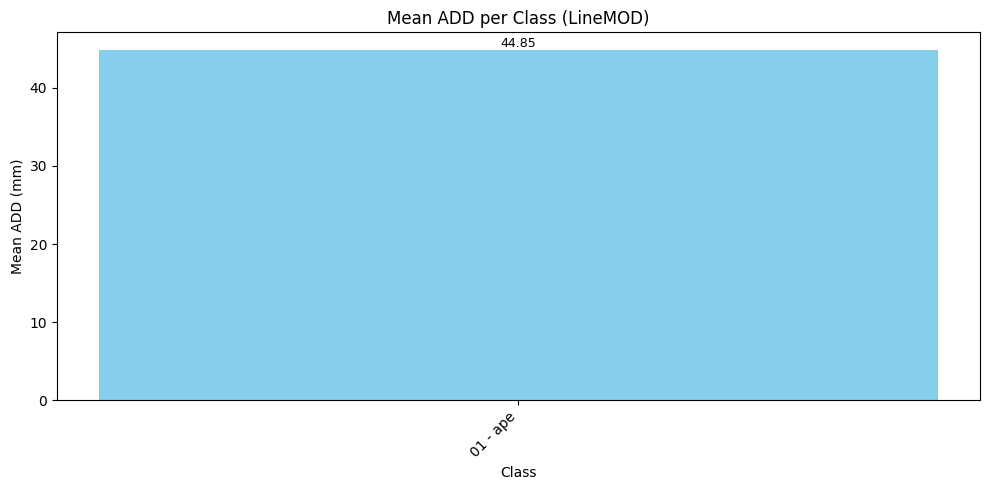

In [7]:
# Grafico a barre delle medie ADD per classe (full pose end-to-end)
results_full_pose = globals().get('results_full_pose', None)
if results_full_pose is None:
    print("⚠️  Devi prima calcolare la metrica ADD full pose su tutto il test set e salvare i risultati in 'results_full_pose'.")
else:
    plot_add_per_class(results_full_pose, Config.LINEMOD_OBJECTS)